In [1]:
from pathlib import Path

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer



2022-02-06 18:29:11.635407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-06 18:29:11.635429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 8)


<center> <h2> Data overview

In [3]:
ROOT_PATH = Path().resolve().parent
DATA_PATH = ROOT_PATH.joinpath("data")
MNIST_TRAIN = DATA_PATH.joinpath("sign_mnist_train.csv")
MNIST_TEST = DATA_PATH.joinpath("sign_mnist_test.csv")



In [4]:
train_df = pd.read_csv(MNIST_TRAIN)
test_df = pd.read_csv(MNIST_TEST)


In [5]:
test = pd.read_csv(MNIST_TEST)
y = test["label"]


In [6]:
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<center> <h2> Preprocessing

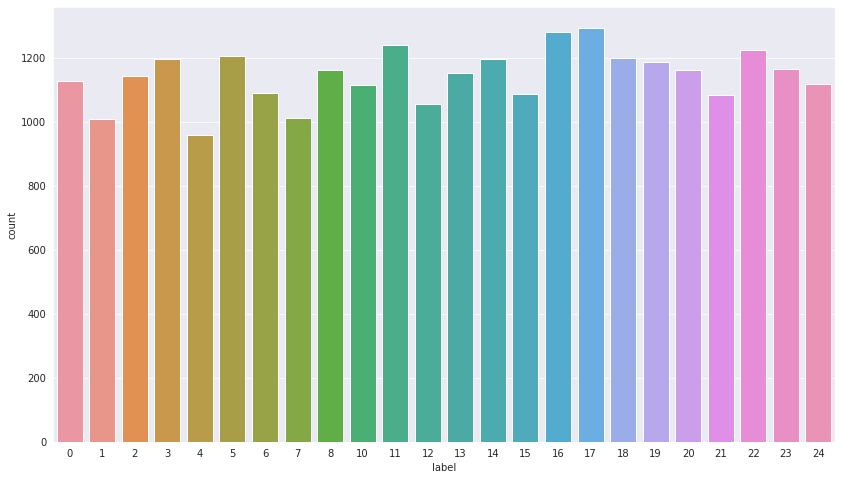

In [7]:
_ = sns.countplot(x=train_df["label"])


In [8]:
y_train, X_train_df = train_df["label"], train_df.drop("label", axis=1)
y_test, X_test_df = test_df["label"], test_df.drop("label", axis=1)



In [9]:

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [10]:
x_train = X_train_df.values
x_test = X_test_df.values


In [11]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255


In [12]:
# Reshaping the to an image with single chanel
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


<center> <h3> Preview of first the images

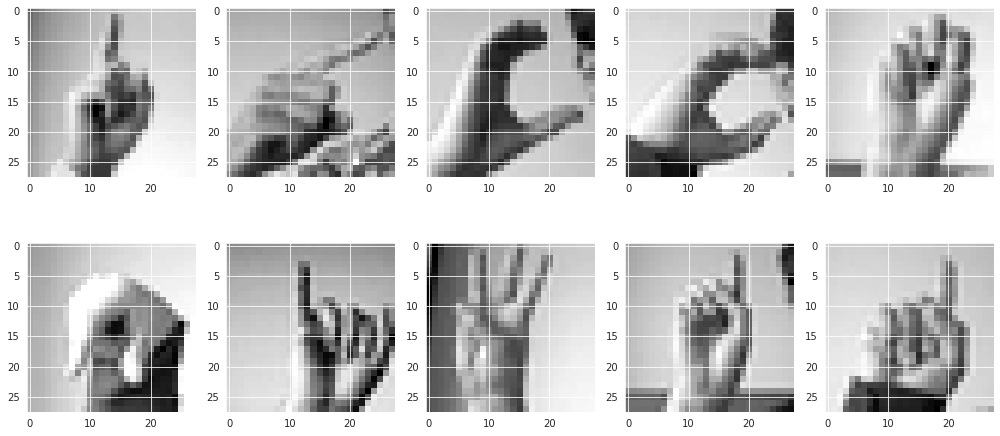

In [13]:
rows, cols = (2, 5)

f, ax = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(x_train[i * cols + j].reshape(28, 28), cmap="gray")
    plt.tight_layout()

plt.show()



# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
)  # randomly flip images


datagen.fit(x_train)


For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE
**A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.**

* **A convolution does this by multiplying two matrices and yielding a third, smaller matrix.**
* **The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.**
* **In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure**
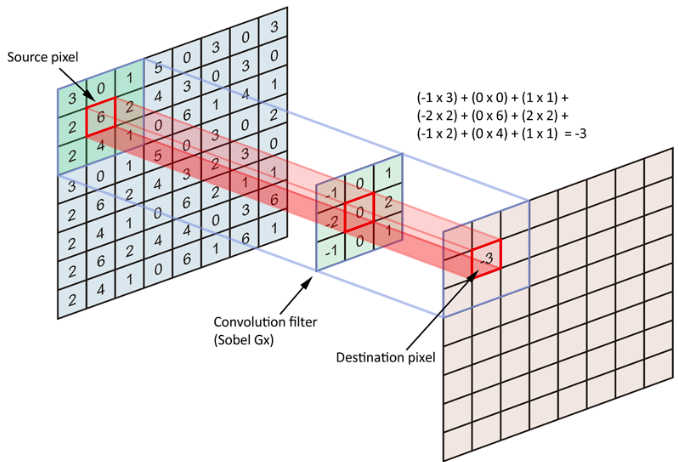

# Training The Model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)



In [ ]:
model = Sequential()
model.add(
    Conv2D(
        75,
        (3, 3),
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=24, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


2022-02-06 02:26:38.530240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-02-06 02:26:38.573641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 02:26:38.573835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 02:26:38.574972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-06 02:26:38.575675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[learning_rate_reduction],
)



Epoch 1/20


2022-02-06 02:26:40.532860: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


215/215 [==============================] - 12s 46ms/step - loss: 1.0689 - accuracy: 0.6674 - val_loss: 3.7915 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 9s 43ms/step - loss: 0.2083 - accuracy: 0.9333 - val_loss: 1.0930 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 10s 45ms/step - loss: 0.0982 - accuracy: 0.9691 - val_loss: 0.4244 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 10s 47ms/step - loss: 0.0684 - accuracy: 0.9784 - val_loss: 0.0394 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 10s 46ms/step - loss: 0.0476 - accuracy: 0.9851 - val_loss: 0.1681 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9878
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 10s 45ms/ste

In [ ]:
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")



225/225 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.9972
Accuracy of the model is -  99.72113966941833 %


# Analysis after Model Training

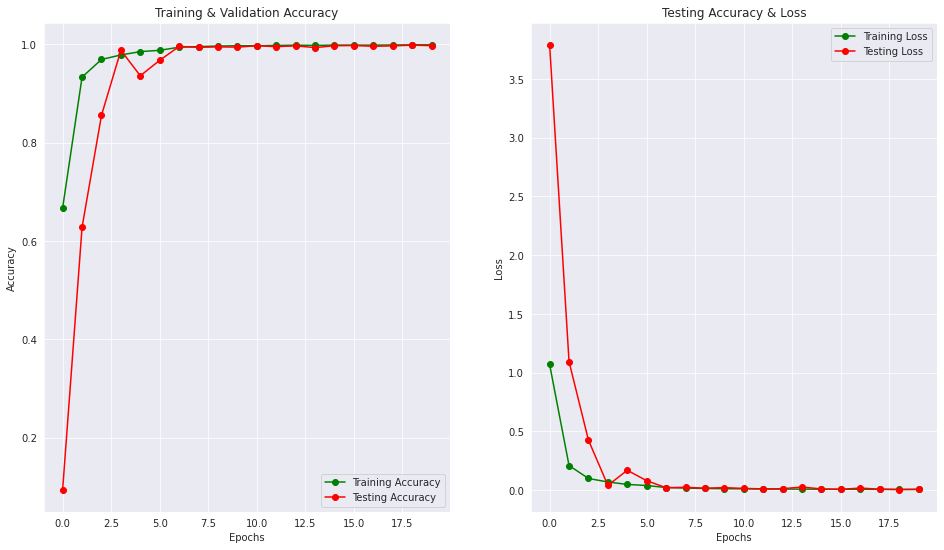

In [ ]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, "go-", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Testing Accuracy")
ax[0].set_title("Training & Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "g-o", label="Training Loss")
ax[1].plot(epochs, val_loss, "r-o", label="Testing Loss")
ax[1].set_title("Testing Accuracy & Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1
predictions[:5]


array([ 6,  5, 10,  0,  3])

In [ ]:
x_test.shape


(7172, 28, 28, 1)

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]

print(predictions.shape, y.shape)

print(classification_report(y, predictions, target_names=classes))



(7172,) (7172,)
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      0.96      0.98       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       0.95      1.00      0.98       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 1

In [ ]:
cm = confusion_matrix(y, predictions)



In [ ]:
cm = pd.DataFrame(
    cm, index=[i for i in range(25) if i != 9], columns=[i for i in range(25) if i != 9]
)



<AxesSubplot:>

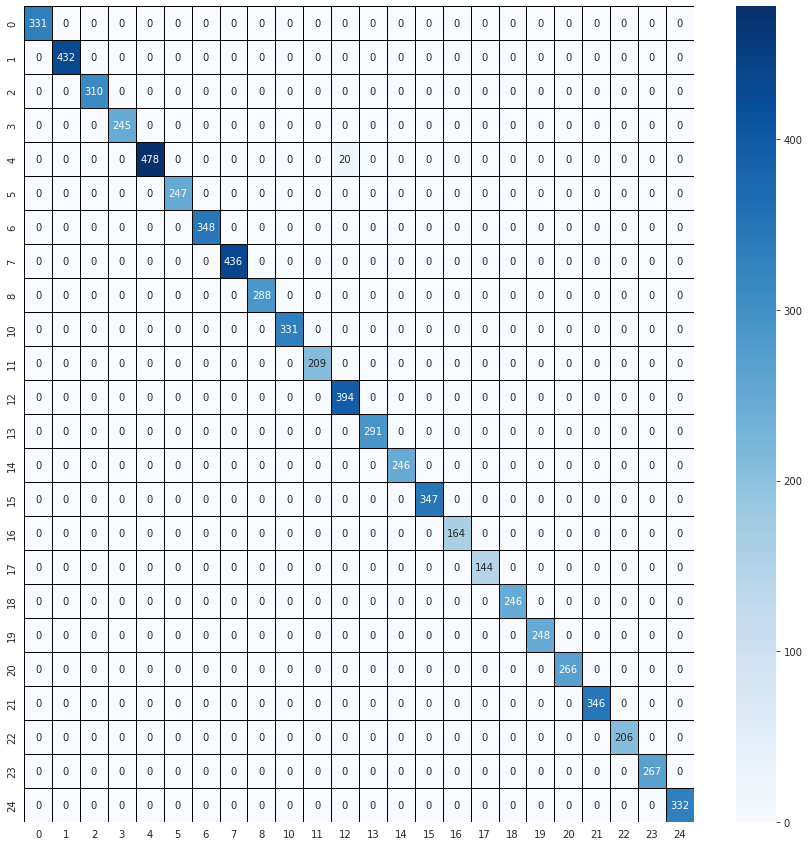

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm, cmap="Blues", linecolor="black", linewidth=1, annot=True, fmt="")



In [ ]:
correct = predictions[predictions == y]
correct.shape
# Would you look at that

(7152,)

**Some of the Correctly Predicted Classes**

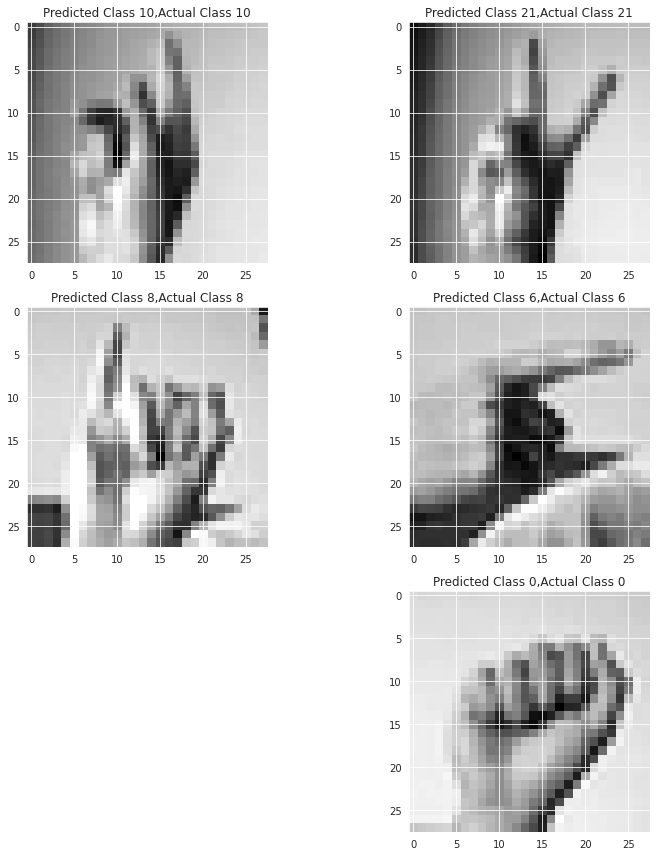

In [ ]:
i = 0
plt.figure(figsize=(12, 12))
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1
